In [1]:
import csv
import sqlite3
import pandas as pd
from contextlib import closing
from time import sleep
from pyacaia import AcaiaScale

In [31]:
print('Please enter the name of the file:')
filename = input()
print('Which Hotend is this:')
hotend = input()
print('What nozzle type:')
nozzle_type = input()
print('And the diameter of the nozzle:')
nozzle_diameter = input()
print('What is the wattage of the heater:')
heater_wattage = input()
splitfile = filename.split('_')

Please enter the name of the file:


 20_2_5_260_10_3


Which Hotend is this:


 v6


What nozzle type:


 cht


And the diameter of the nozzle:


 0.5


What is the wattage of the heater:


 40


In [32]:
scale=AcaiaScale(mac='34:81:f4:de:de:a7')
scale.connect()

INFO:root:Scale Ready!


In [33]:
scale.weight

0.06

In [34]:
flow_start = int(splitfile[0])
flow_step_increase = int(splitfile[1])
flow_steps = int(splitfile[2])
flow_end = flow_start + ((flow_steps - 1) * flow_step_increase)
temp_start = int(splitfile[3])
temp_step_increase = int(splitfile[4])
temp_steps = int(splitfile[5].split('.')[0])
temp_end = temp_start + ((temp_steps - 1) * temp_step_increase)
extruded_blobs_to_weigh = flow_steps * temp_steps
flow_step_measured_count = 0
temp_step_measured_count = 0
flow_table = {}

In [10]:
temp_steps

4

In [35]:
while temp_step_measured_count < temp_steps:
    scale_not_reading = False
    temp_step = temp_start + (temp_step_measured_count * temp_step_increase)
    flow_table[temp_step] = {}
    while flow_step_measured_count < flow_steps:
        flow_step = flow_start + (flow_step_measured_count * flow_step_increase)
        print(f'Hit enter once you have placed the blob on the scale for {temp_step}C at {flow_step}mm/s^3')
        input()
        weight_count = 0
        measured_weights = []
        while weight_count < 6:
            measured_weight = scale.weight
            if measured_weight == 'None':
                print('Scale is not recording, please reconnect and try again.')
                scale_not_reading = True
                break
            measured_weights.append(scale.weight)
            sleep(0.2)
            weight_count += 1
        averaged_weight = round(sum(measured_weights) / len(measured_weights),2)
        print(f'Recording a weight of {averaged_weight}')
        flow_table[temp_step][flow_step] = averaged_weight
        flow_step_measured_count += 1
    if scale_not_reading:
        break
    flow_step_measured_count = 0
    temp_step_measured_count += 1
print('Done recording!')

Hit enter once you have placed the blob on the scale for 260C at 20mm/s^3


Recording a weight of 0.96
Hit enter once you have placed the blob on the scale for 260C at 22mm/s^3


Recording a weight of 0.94
Hit enter once you have placed the blob on the scale for 260C at 24mm/s^3


Recording a weight of 0.9
Hit enter once you have placed the blob on the scale for 260C at 26mm/s^3


Recording a weight of 0.8
Hit enter once you have placed the blob on the scale for 260C at 28mm/s^3


Recording a weight of 0.71
Hit enter once you have placed the blob on the scale for 270C at 20mm/s^3


Recording a weight of 0.95
Hit enter once you have placed the blob on the scale for 270C at 22mm/s^3


Recording a weight of 0.96
Hit enter once you have placed the blob on the scale for 270C at 24mm/s^3


Recording a weight of 0.94
Hit enter once you have placed the blob on the scale for 270C at 26mm/s^3


Recording a weight of 0.9
Hit enter once you have placed the blob on the scale for 270C at 28mm/s^3


Recording a weight of 0.82
Hit enter once you have placed the blob on the scale for 280C at 20mm/s^3


Recording a weight of 0.96
Hit enter once you have placed the blob on the scale for 280C at 22mm/s^3


Recording a weight of 0.95
Hit enter once you have placed the blob on the scale for 280C at 24mm/s^3


Recording a weight of 0.95
Hit enter once you have placed the blob on the scale for 280C at 26mm/s^3


Recording a weight of 0.95
Hit enter once you have placed the blob on the scale for 280C at 28mm/s^3


Recording a weight of 0.91
Done recording!


In [36]:
flow_table

{260: {20: 0.96, 22: 0.94, 24: 0.9, 26: 0.8, 28: 0.71},
 270: {20: 0.95, 22: 0.96, 24: 0.94, 26: 0.9, 28: 0.82},
 280: {20: 0.96, 22: 0.95, 24: 0.95, 26: 0.95, 28: 0.91}}

In [13]:
flow_table = {230: {10: 1.03, 12: 1.01, 14: 1.02, 16: 0.95, 18: 0.83},
 240: {10: 1.04, 12: 1.03, 14: 1.04, 16: 1.03, 18: 1.01},
 250: {10: 1.04, 12: 1.08, 14: 1.06, 16: 1.06, 18: 1.06},
 260: {10: 1.10, 12: 1.07, 14: 1.07, 16: 1.07, 18: 1.07}}

In [37]:
with open(f'assets/csv/{hotend}_{nozzle_type}_{nozzle_diameter}_{heater_wattage}w_{flow_start}-{flow_end}_{temp_start}-{temp_end}.csv', 'w') as f:
    f.write('hotend, nozzle, nozzle_diameter, heater_wattage, temperature, flow_rate, measured_weight\n')
    for temp in flow_table.keys():
        for rate in flow_table[temp].keys():
            f.write(f'{hotend}, {nozzle_type}, {nozzle_diameter}, {heater_wattage}, {temp}, {rate}, {flow_table[temp][rate]}\n')

In [38]:
connection = sqlite3.connect("flow_rates.db")
cur = connection.cursor()

In [39]:
for temp in flow_table.keys():
    for rate in flow_table[temp].keys():
        cur.execute(f"INSERT INTO flow_rate_data ('hotend', 'nozzle', 'nozzle_diameter', 'heater_wattage', 'temperature', 'flow_rate', 'measured_weight') VALUES ('{hotend}', '{nozzle_type}', '{nozzle_diameter}', '{heater_wattage}', '{temp}', '{rate}', '{flow_table[temp][rate]}')")
connection.commit()
connection.close()

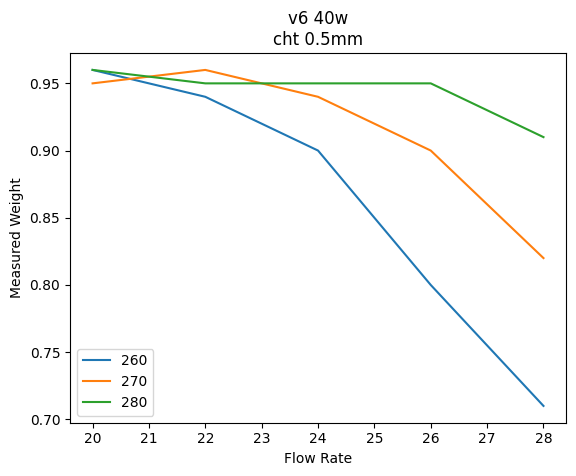

In [40]:
data = pd.DataFrame(flow_table)
dataplot = data.plot(xlabel='Flow Rate', ylabel='Measured Weight', title=f'{hotend} {heater_wattage}w\n{nozzle_type} {nozzle_diameter}mm')
datapng = dataplot.get_figure()
datapng.savefig(f"assets/img/{hotend}_{nozzle_type}_{nozzle_diameter}_{heater_wattage}w_{temp_start}C-{temp_end}C_{flow_start}-{flow_end}.png")